In [50]:
root_path = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_val/"
path_pesi_old = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_val/pesi/pesi.h5"
history_saving_path_json = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_val/history.json"
save_checkpoints_path = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_val/modellozzo_ckpt"
path_root = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware"



In [51]:

class_index = {'Adialer.C': 0,
                'Agent.FYI': 1,
                'Allaple.A': 2,
                'Allaple.L': 3,
                'Alueron.gen!J': 4,
                'Autorun.K': 5,
                'C2LOP.P': 6,
                'C2LOP.gen!g': 7,
                'Dialplatform.B': 8,
                'Dontovo.A': 9,
                'Fakerean': 10,
                'Instantaccess': 11,
                'Lolyda.AA1': 12,
                'Lolyda.AA2': 13,
                'Lolyda.AA3': 14,
                'Lolyda.AT': 15,
                'Malex.gen!J': 16,
                'Obfuscator.AD': 17,
                'Rbot!gen': 18,
                'Skintrim.N': 19,
                'Swizzor.gen!E': 20,
                'Swizzor.gen!I': 21,
                'VB.AT': 22,
                'Wintrim.BX': 23,
                'Yuner.A': 24}

# **Setting up the dataset**

In [52]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [54]:
train_df=pd.read_csv(os.path.join(path_root,"train_2.csv"))
test_df=pd.read_csv(os.path.join(path_root,"test_2.csv"))
val_df=pd.read_csv(os.path.join(path_root,"val_2.csv"))

In [55]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
        rescale=1 / 255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 5623 validated image filenames belonging to 25 classes.
Found 1858 validated image filenames belonging to 25 classes.
Found 1858 validated image filenames belonging to 25 classes.


In [56]:

classes = train_gen.class_indices

# **Image plot of malware samples**

In [57]:
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,len(classes)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)

        img = cv2.imread(ims[i])
        print(ims[i])
        img = cv2.resize(img,target_size_custom) #per plottare senza preprocessing

        plt.imshow(img,cmap='gray', interpolation=None if interp else 'none')


/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware/Adialer.C/002f06eff1d222560939be72583d6ae9.png
/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware/Agent.FYI/00443069b59f9b9682cf044dcbd498c7.png
/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware/Allaple.A/06c49bdf092e43d36bcbe6cf8f4d5c7c.png
/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware/Allaple.L/0389fb00d757455198ddbb22f4694c1d.png
/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware/Alueron.gen!J/000c3e6a835acef29cfe96d8587efbbb.png
/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware/Autorun.K/001356b73bdeada80637d37d449529c5.png
/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware/C2LOP.P/00051420759dd13d0d8a217c23dafb54.p

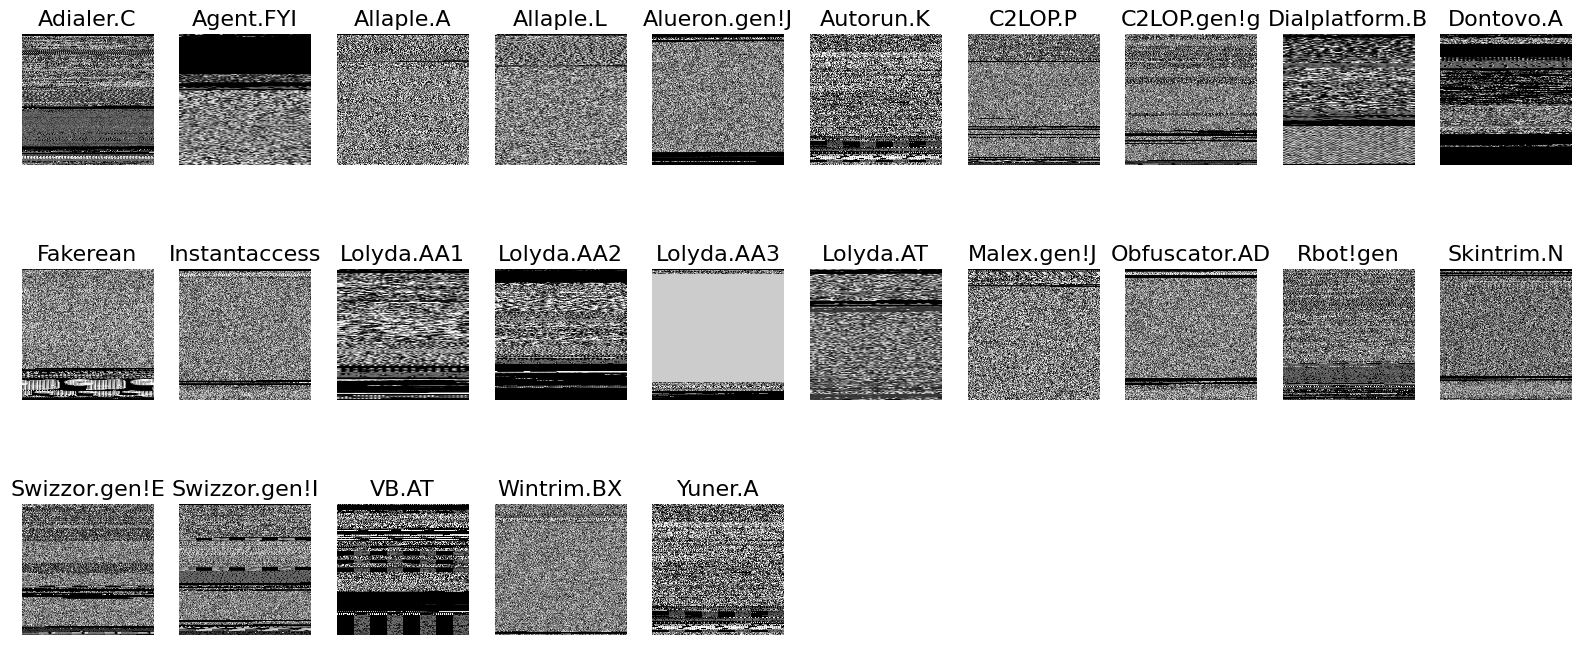

In [58]:

samples = []
keys = []

for classe in val_gen.class_indices.keys():
  samples.append(os.path.join(path_root,(classe + "/" + os.listdir(os.path.join(path_root,classe))[0])))
  keys.append(classe)

plots(samples, titles = keys)


# **Analysis of class distribution**



In [59]:
total_samples = pd.concat([train_df, test_df, val_df], ignore_index=True)

In [60]:
total_samples

,Unnamed: 0,img_code,target
0,0,./Adialer.C/06d931db1678f133a58a3b29603e72f9.png,Adialer.C
1,1,./Adialer.C/065b51cdf941073bb720bc01d515dae1.png,Adialer.C
2,2,./Adialer.C/068f9e521028f506b8152b923c4bebb7.png,Adialer.C
3,3,./Adialer.C/06cfd6ce7c118b76e73e081304254457.png,Adialer.C
4,4,./Adialer.C/06e21af7e2fdd67622d0122e113b0d53.png,Adialer.C
...,...,...,...
9334,1853,./Yuner.A/019411b1008b1778c6494221281f0649.png,Yuner.A
9335,1854,./Yuner.A/0194f30b4816504129063dc382aa7b6d.png,Yuner.A
9336,1855,./Yuner.A/019366db7703fb9d774c3c2eba8dc395.png,Yuner.A
9337,1856,./Yuner.A/017e168adf825b95ad32392db28f56b8.png,Yuner.A


In [61]:

occurences = total_samples.groupby(by = "target").size()

<BarContainer object of 25 artists>

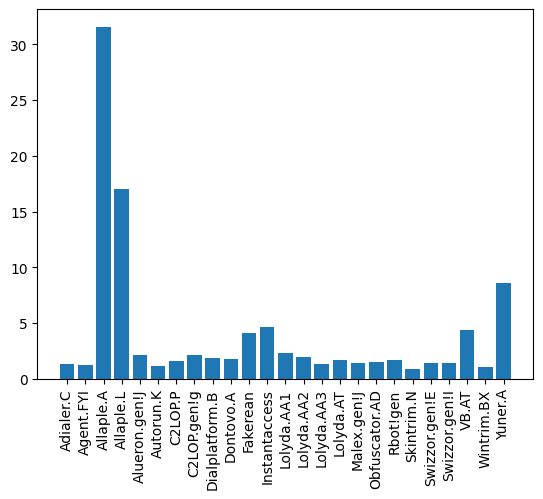

In [62]:
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), occurences/sum(occurences)*100)

# **Analysis of class distribution for each subset**

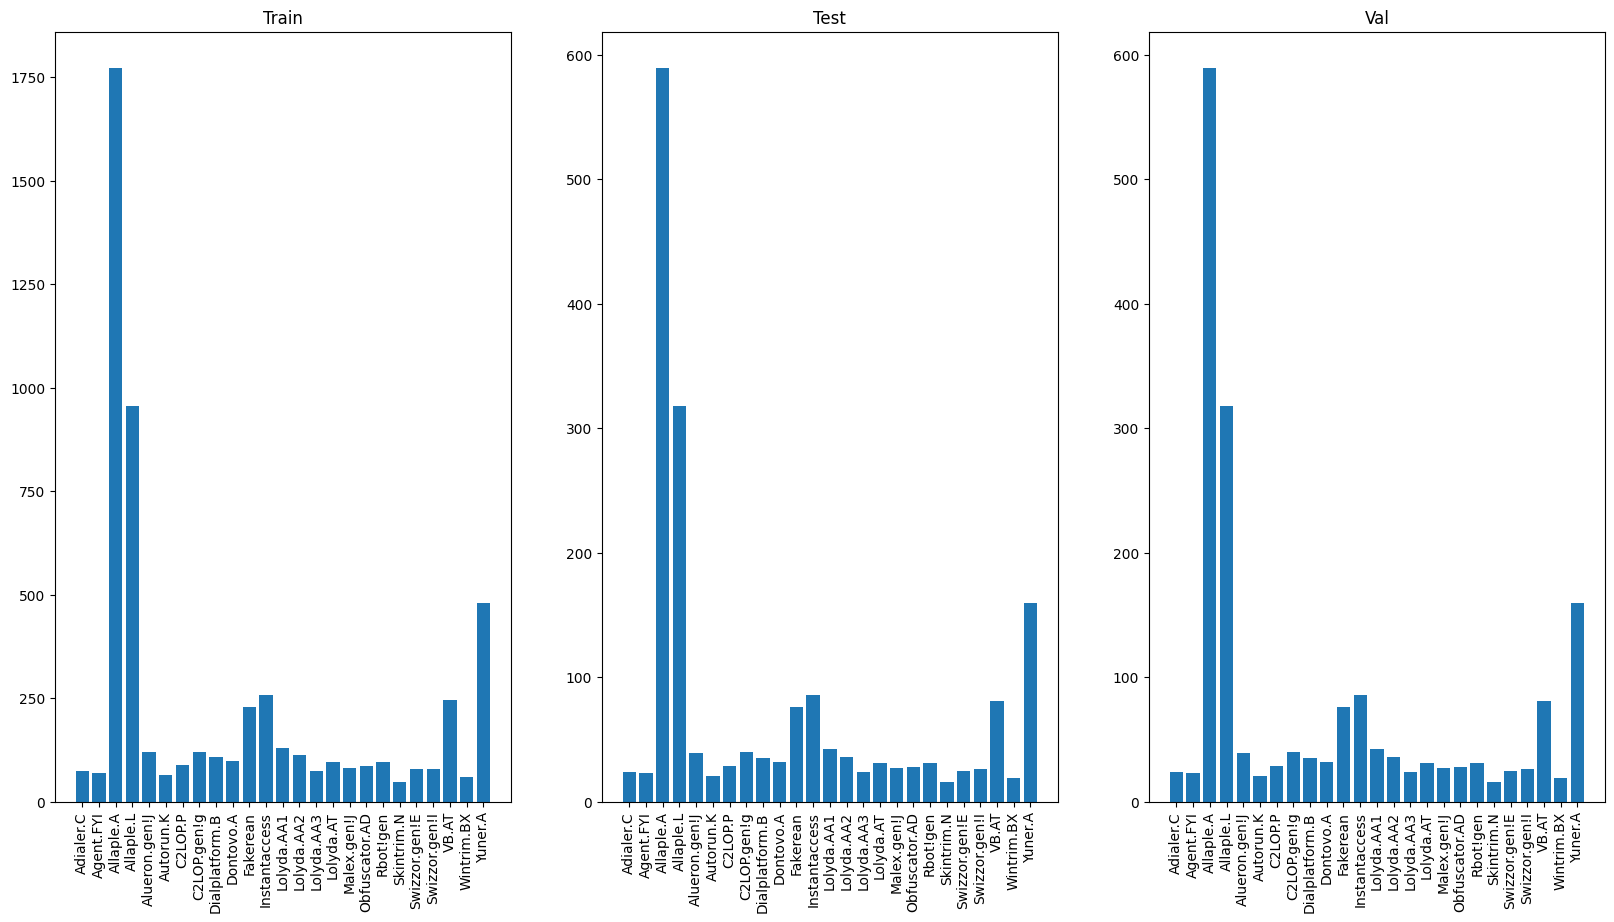

In [63]:
train_occ = train_df.groupby(by = "target").size()
test_occ = test_df.groupby(by = "target").size()
val_occ = val_df.groupby(by = "target").size()

occur = [train_occ, test_occ, val_occ]
name = ["Train", "Test", "Val"]

plt.figure(figsize = (20,10))

for i in range(3):

  plt.subplot(1,3,i+1)
  plt.title(name[i])
  plt.xticks(rotation = "vertical")
  plt.bar(classes.keys(), occur[i])

plt.show()

# **Class weight calculationt**

In [64]:
train_labels = train_df.replace({"target":class_index})['target'].to_numpy()
class_indices =np.array(list(class_index.values()))
class_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [65]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = class_indices,
                                                  y = train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 3.0394594594594593,
 1: 3.213142857142857,
 2: 0.1270016939582157,
 3: 0.23551832460732985,
 4: 1.8743333333333334,
 5: 3.514375,
 6: 2.555909090909091,
 7: 1.8743333333333334,
 8: 2.102056074766355,
 9: 2.2951020408163267,
 10: 0.9821834061135372,
 11: 0.8684169884169884,
 12: 1.7435658914728682,
 13: 2.0082142857142857,
 14: 2.9989333333333335,
 15: 2.318762886597938,
 16: 2.742926829268293,
 17: 2.6153488372093023,
 18: 2.3429166666666665,
 19: 4.685833333333333,
 20: 2.8835897435897437,
 21: 2.8115,
 22: 0.9143089430894309,
 23: 3.8122033898305085,
 24: 0.46858333333333335}

<BarContainer object of 25 artists>

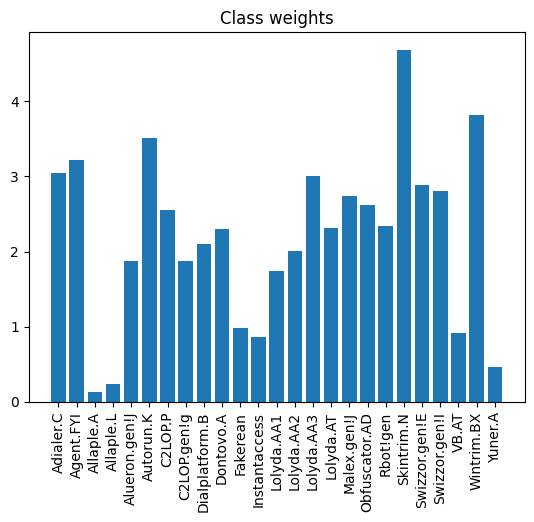

In [66]:
plt.title("Class weights")
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), class_weights.values())

# **Building the CNN**

In [67]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [68]:
num_classes = len(classes)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model

In [69]:

Malware_model = malware_model()
Malware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 32)       

In [70]:
cp_callback = ModelCheckpoint(save_checkpoints_path, verbose =1, monitor = "val_accuracy")

In [72]:
#Malware_model.load_weights(filepath = save_checkpoints_path, skip_mismatch=False, by_name=False, options=None)

In [73]:
history = Malware_model.fit(train_gen,validation_data=val_gen, epochs=10,  class_weight=class_weights, callbacks = [cp_callback])

Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: 2.7285 - accuracy: 0.1421 - weighted_accuracy: 0.1867
Epoch 1: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_val/modellozzo_ckpt
176/176 [==============================] - 993s 6s/step - loss: 2.7285 - accuracy: 0.1421 - weighted_accuracy: 0.1867 - val_loss: 1.8900 - val_accuracy: 0.4483 - val_weighted_accuracy: 0.4483
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: 1.3878 - accuracy: 0.4535 - weighted_accuracy: 0.5630
Epoch 2: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_val/modellozzo_ckpt
176/176 [==============================] - 915s 5s/step - loss: 1.3878 - accuracy: 0.4535 - weighted_accuracy: 0.5630 - val_loss: 0.9623 - val_accuracy: 0.6109 - val_weighted_accuracy: 0.6109
Epoch 3/10
176/176 [==============================] - ETA: 0s - loss: 0.8250 - accuracy: 0.6498 - weighted_accur

# **History saving**

In [84]:

hist_df = pd.DataFrame(history.history)
with open(history_saving_path_json, 'wb') as file_pi:
    hist_df.to_json(file_pi)

# **Model training plots**

dict_keys(['loss', 'accuracy', 'weighted_accuracy', 'val_loss', 'val_accuracy', 'val_weighted_accuracy'])


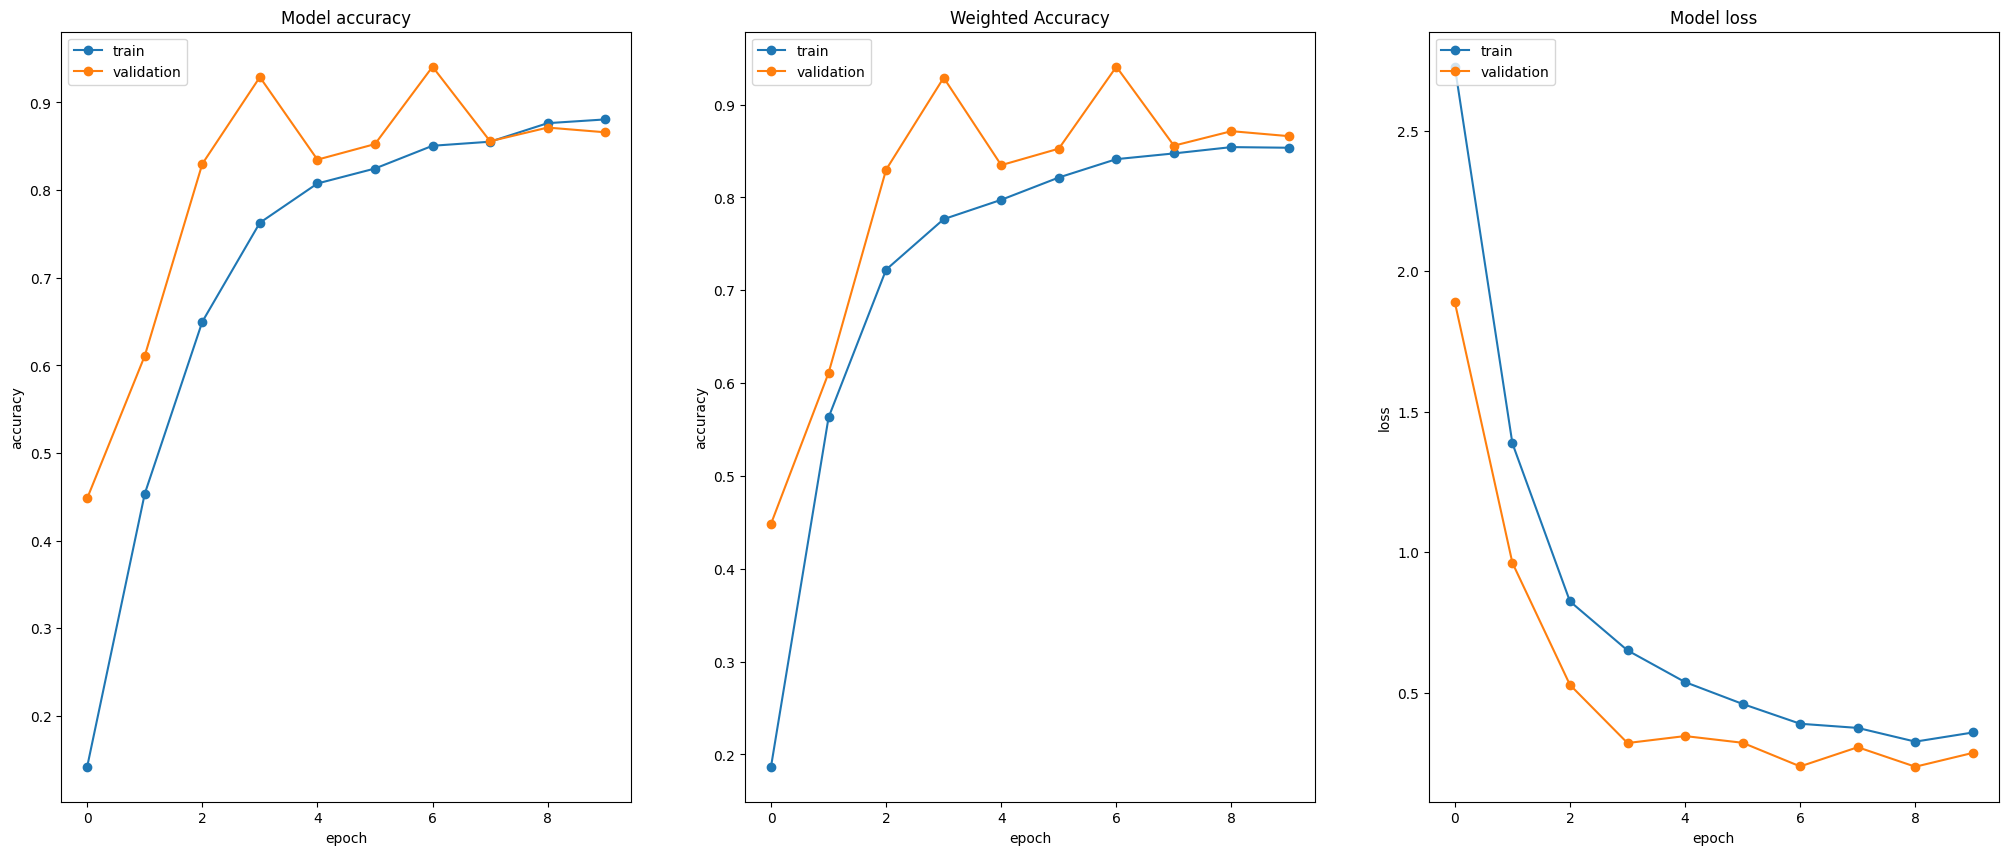

In [85]:
print(history.history.keys())
plt.figure(figsize = (25,10))
#  "Accuracy"
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#  "Weighted Accuracy"
plt.subplot(1,3,2)
plt.plot(history.history['weighted_accuracy'], marker='o')
plt.plot(history.history['val_weighted_accuracy'], marker='o')
plt.title('Weighted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# "Loss"
plt.subplot(1,3,3)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Results on Validation Set**

In [86]:
metric_list = Malware_model.evaluate(val_gen, batch_size=32, verbose=1)

print('evaluate_accuracy=%.3f' %metric_list[1])
print('evaluate_weighted_accuracy=%.3f' %metric_list[2])

59/59 [==============================] - 80s 1s/step - loss: 0.2856 - accuracy: 0.8660 - weighted_accuracy: 0.8660
evaluate_accuracy=0.866
evaluate_weighted_accuracy=0.866


# **Confusion matrix**

In [87]:

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

y_pred = Malware_model.predict(val_gen)
y_test_predicted = np.argmax(np.array(y_pred),axis = 1)

Found 1858 validated image filenames belonging to 25 classes.
59/59 [==============================] - 76s 1s/step


In [88]:

from sklearn import metrics

In [89]:

c_matrix = metrics.confusion_matrix(val_gen.classes, y_test_predicted)
df_confusion = pd.crosstab(val_gen.classes, y_test_predicted)
df_confusion.to_csv(os.path.join(root_path,"confusion_matrix.csv"))

In [90]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


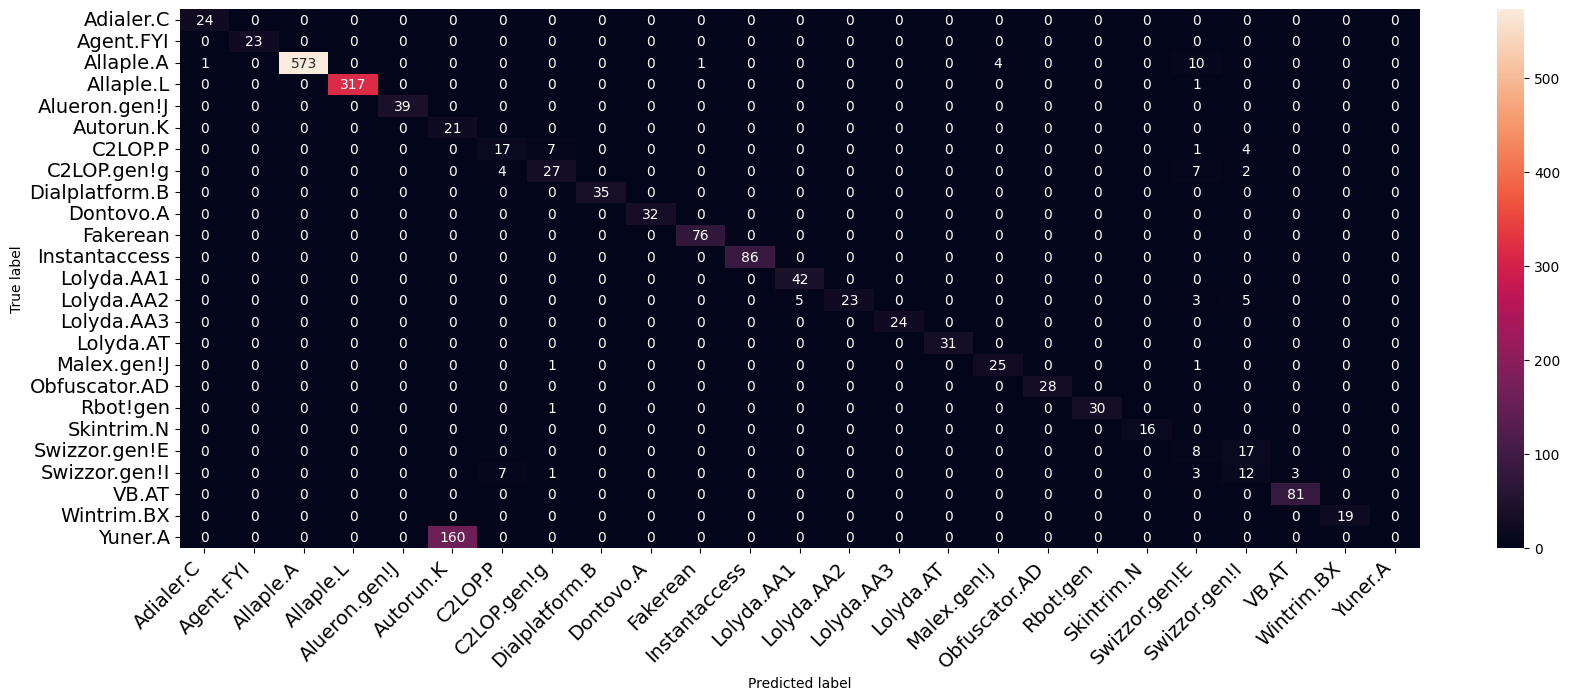

In [81]:

confusion_matrix(c_matrix, classes, figsize = (20,7), fontsize=14)

In [82]:
report = metrics.classification_report(val_gen.classes, y_test_predicted, target_names=classes,  output_dict=True)
print(report)


{'Adialer.C': {'precision': 0.96, 'recall': 1.0, 'f1-score': 0.9795918367346939, 'support': 24}, 'Agent.FYI': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23}, 'Allaple.A': {'precision': 1.0, 'recall': 0.9728353140916808, 'f1-score': 0.9862306368330465, 'support': 589}, 'Allaple.L': {'precision': 1.0, 'recall': 0.9968553459119497, 'f1-score': 0.9984251968503937, 'support': 318}, 'Alueron.gen!J': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 39}, 'Autorun.K': {'precision': 0.11602209944751381, 'recall': 1.0, 'f1-score': 0.2079207920792079, 'support': 21}, 'C2LOP.P': {'precision': 0.6071428571428571, 'recall': 0.5862068965517241, 'f1-score': 0.5964912280701754, 'support': 29}, 'C2LOP.gen!g': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987014, 'support': 40}, 'Dialplatform.B': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35}, 'Dontovo.A': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 32}, 'Fak

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:

df_report = pd.DataFrame(report).transpose()
df_report = df_report.round({'precision': 5, 'recall': 5, 'f1-score': 5})
df_report.to_csv(os.path.join(root_path,"report.csv"), index = False)